# NOAA 自然重建数据的处理

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import pandas as pd
import numpy as np
import os
from hydra import compose, initialize
from mksci_font import config_font

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

config_font({"font.size": 9})

## 筛选数据

In [2]:
from past1000.calibration import load_nat_data

included = [
    # "hexi2019scpdsi",
    "qinling2016precip",
    "shanxi2015precip",
    "tan2011precip-noaa",
    # "xu2023-asm",
    # "yellow2019flow",
    # "yellow2020flow",
    "north-china-precip2010",
    "north-china-temp-precip2011",
]

datasets, uncertainties = load_nat_data(
    folder=cfg.ds.noaa,
    includes=included,
    start_year=1000,
    standardize=True,
)
datasets.tail()

Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.
Found 18 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
Found 5 files matching the pattern.


,north-china-precip2010,shanxi2015precip,tan2011precip-noaa,qinling2016precip,north-china-temp-precip2011
year,,,,,
2006,NaN,NaN,NaN,-1.393241,NaN
2007,NaN,NaN,NaN,-1.385078,NaN
2008,NaN,NaN,NaN,-1.692960,NaN
2009,NaN,NaN,NaN,-0.568723,NaN
2010,NaN,NaN,NaN,0.307108,NaN


最佳分布：Student-t（t）表现最佳：

- 最低sumsquare_error（1.003480），表明直方图拟合最好。
- 较低的AIC（495.670695）和BIC（507.652580），优于lognorm和gamma。
- 最低ks_statistic（0.040494）和最高ks_pvalue（0.5134515），CDF拟合极佳。

次佳分布：lognorm：
- sumsquare_error（1.010543）、AIC（500.570491）、BIC（512.552375）略逊于t。
- ks_statistic（0.040599）和ks_pvalue（0.5101007）与t接近，拟合良好。

> [!info] AIC（赤池信息准则，Akaike Information Criterion）
> 
> AIC衡量模型的拟合优度与复杂度的平衡，公式为：
> $$\text{AIC} = 2k - 2\ln(L)$$
> 其中，k是模型参数数量，L是似然函数的最大值（反映拟合优度）。
> 低AIC表示模型在拟合数据和简洁性之间取得更好平衡，说明模型拟合数据好且不过于复杂。
> 比较模型：AIC用于比较不同模型（如Student-t、lognorm），但仅在同一数据集上有效。AIC不衡量绝对拟合质量，仅用于相对比较；对样本量敏感。

> [!info] BIC（贝叶斯信息准则，Bayesian Information Criterion）
> 
> BIC类似AIC，但对模型复杂度的惩罚更严格，公式为：
> $$\text{BIC} = k \ln(n) - 2\ln(L)$$
> 其中，k是参数数量，n是样本量，L是最大似然值。
> 低BIC表示模型拟合好且不过于复杂。

> [!info] ks_statistic（K-S检验统计量）
> 
> K-S检验统计量衡量数据与理论分布之间的最大偏差，公式为：
> $$\text{ks_statistic} = \max(|F_n(x) - F(x)|)$$
> 其中，F_n(x)是经验累积分布函数，F(x)是理论分布函数。
> 低ks_statistic表示数据与理论分布之间的最大偏差较小，说明拟合良好。
> 
> p值>0.05：拟合分布合理，数据可能来自该分布。
> p值<0.05：拒绝零假设，分布不适合数据。
> 
> 与ks_statistic结合：低ks_statistic和高ks_pvalue表示拟合好。

> [!info] sumsquare_error（平方误差和）
> 
> 平方误差和衡量数据与理论分布之间的差异，公式为：
> $$\text{sumsquare_error} = \sum(F_n(x) - F(x))^2$$
> 其中，F_n(x)是经验累积分布函数，F(x)是理论分布函数。


<Figure size 400x300 with 0 Axes>

Text(0.5, 0, 'Mean: -0.00, Std: 1.00')

2025-06-12 14:42:58.659 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=1.377051)
2025-06-12 14:42:58.670 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted exponpow distribution with error=1.06784)
2025-06-12 14:42:58.675 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=1.05305)
2025-06-12 14:42:58.694 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=1.047874)
2025-06-12 14:42:58.701 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=4.49392)
2025-06-12 14:42:58.825 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=1.010712)
2025-06-12 14:42:58.842 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=2.994103)
2025-06-12 14:42:58.861 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerla

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
t,1.003480,495.670695,507.652580,inf,0.040494,0.513451
lognorm,1.010543,500.570491,512.552375,inf,0.040599,0.510101
norm,1.010712,497.202106,505.190029,inf,0.042146,0.462045
chi2,1.047874,504.171838,516.153722,inf,0.048667,0.288867
gamma,1.053050,503.329557,515.311441,inf,0.054712,0.174655


Text(0.5, 1.0, 'north-china-precip2010')

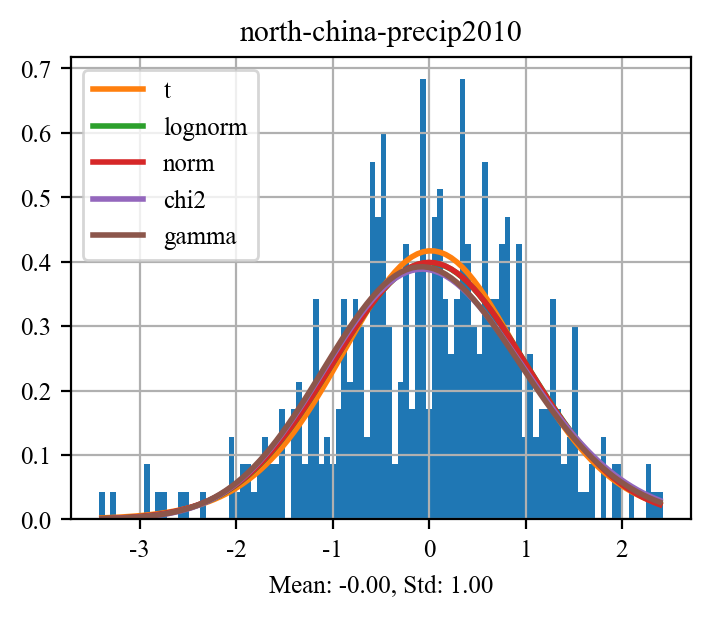

<Figure size 400x300 with 0 Axes>

Text(0.5, 0, 'Mean: -0.00, Std: 1.00')

2025-06-12 14:42:59.113 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=6.146119)
2025-06-12 14:42:59.120 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=2.880497)
2025-06-12 14:42:59.124 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=3.921035)
2025-06-12 14:42:59.125 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=4.906511)
2025-06-12 14:42:59.126 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=4.850333)
2025-06-12 14:42:59.126 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=13.727865)
2025-06-12 14:42:59.136 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=2.959964)
2025-06-12 14:42:59.143 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted t

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
t,2.819712,460.004579,468.652985,inf,0.086142,0.265646
norm,2.880497,454.883976,460.649580,inf,0.093210,0.189355
lognorm,2.889574,457.638584,466.286989,inf,0.095225,0.171061
cauchy,2.897848,483.210624,488.976227,inf,0.092716,0.194062
exponpow,2.908729,465.078240,473.726645,inf,0.091182,0.209263


Text(0.5, 1.0, 'shanxi2015precip')

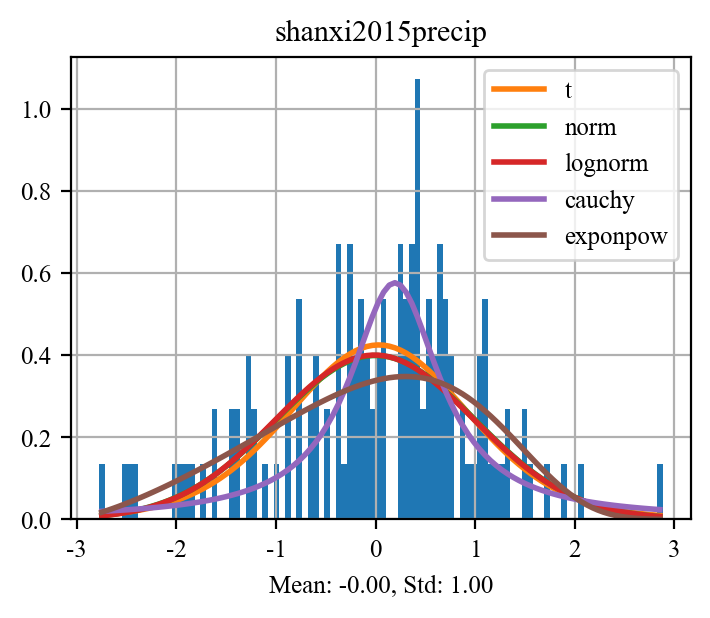

<Figure size 400x300 with 0 Axes>

Text(0.5, 0, 'Mean: -0.51, Std: 0.93')

2025-06-12 14:42:59.929 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=7.415198)
2025-06-12 14:42:59.931 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=10.478922)
2025-06-12 14:42:59.940 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=6.759237)
2025-06-12 14:42:59.943 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=8.066179)
2025-06-12 14:42:59.945 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=8.266992)
2025-06-12 14:42:59.946 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=7.329406)
2025-06-12 14:42:59.946 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=6.808875)
2025-06-12 14:42:59.949 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,6.759237,352.906872,357.950449,inf,0.057617,0.902688
t,6.759237,354.906869,362.472234,inf,0.057618,0.902683
lognorm,6.763129,355.407040,362.972405,inf,0.058953,0.887595
gamma,6.763512,355.142419,362.707785,inf,0.059377,0.882587
chi2,6.808875,355.913871,363.479237,inf,0.070917,0.716743


Text(0.5, 1.0, 'tan2011precip-noaa')

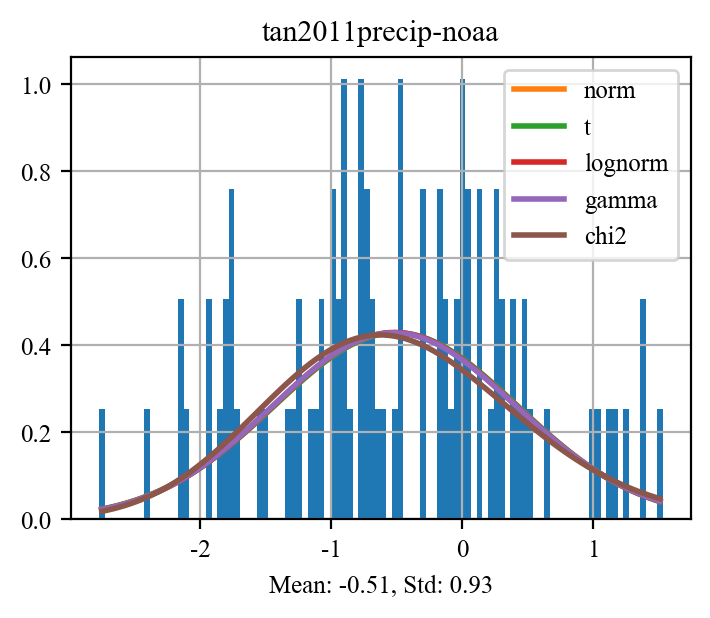

<Figure size 400x300 with 0 Axes>

Text(0.5, 0, 'Mean: -0.00, Std: 1.00')

2025-06-12 14:43:00.158 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.568313)
2025-06-12 14:43:00.163 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=4.217843)
2025-06-12 14:43:00.168 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.609299)
2025-06-12 14:43:00.170 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=2.615026)
2025-06-12 14:43:00.170 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=2.119387)
2025-06-12 14:43:00.172 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=4.361839)
2025-06-12 14:43:00.172 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=2.860673)
2025-06-12 14:43:00.179 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted g

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
t,0.461476,512.808013,525.688271,inf,0.030158,0.697089
cauchy,0.568313,514.483400,523.070238,inf,0.070940,0.008203
norm,0.609299,513.068743,521.655582,inf,0.062044,0.029740
lognorm,0.609683,516.495515,529.375773,inf,0.061874,0.030431
gamma,0.675813,513.213337,526.093595,inf,0.075923,0.003698


Text(0.5, 1.0, 'qinling2016precip')

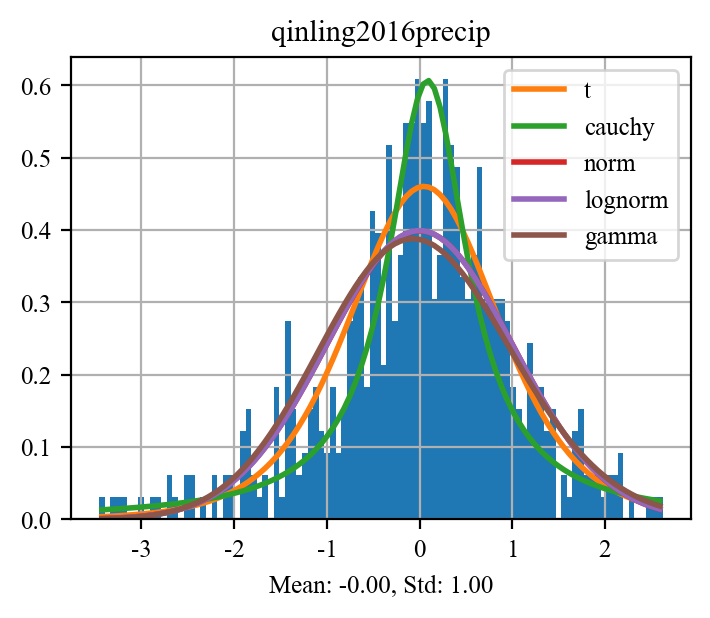

<Figure size 400x300 with 0 Axes>

Text(0.5, 0, 'Mean: 0.00, Std: 1.00')

2025-06-12 14:43:00.356 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.792161)
2025-06-12 14:43:00.359 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=3.468804)
2025-06-12 14:43:00.367 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.522392)
2025-06-12 14:43:00.369 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=1.494283)
2025-06-12 14:43:00.371 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=2.704996)
2025-06-12 14:43:00.372 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=2.714983)
2025-06-12 14:43:00.375 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=9.815703)
2025-06-12 14:43:00.375 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted g

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
t,0.492981,584.286043,597.121607,inf,0.026258,0.846268
norm,0.522392,610.767746,619.324789,inf,0.036879,0.452431
lognorm,0.525153,607.679060,620.514625,inf,0.035158,0.513881
gamma,0.525165,607.492911,620.328476,inf,0.035533,0.500186
cauchy,0.792161,544.949541,553.506584,inf,0.071725,0.007885


Text(0.5, 1.0, 'north-china-temp-precip2011')

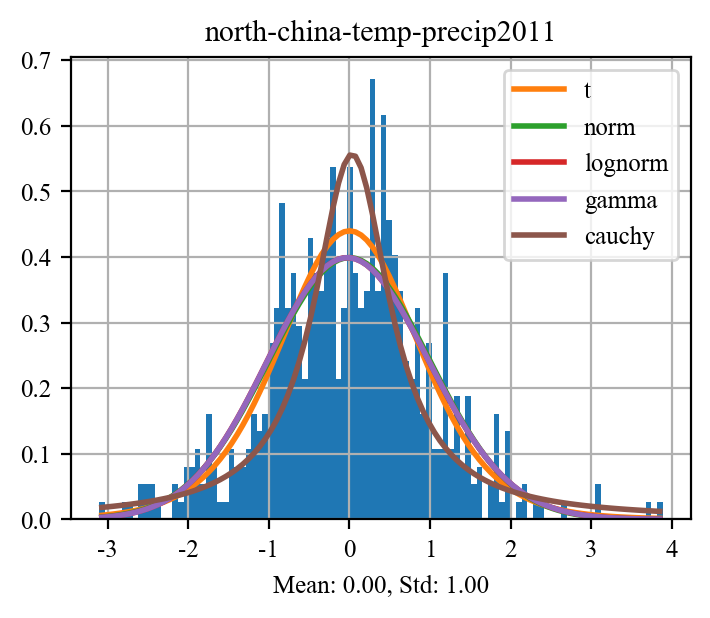

In [3]:
from fitter import Fitter
from fitter import get_common_distributions
from matplotlib import pyplot as plt


common_distributions = get_common_distributions()
common_distributions.append("t")

for col in datasets.columns:
    plt.figure(figsize=(4, 3))
    data = datasets[col].dropna().values
    plt.xlabel(f"Mean: {np.mean(data):.2f}, Std: {np.std(data):.2f}")
    f = Fitter(data, distributions=common_distributions)
    f.fit()
    f.summary(clf=False)
    plt.title(col)
    plt.show()

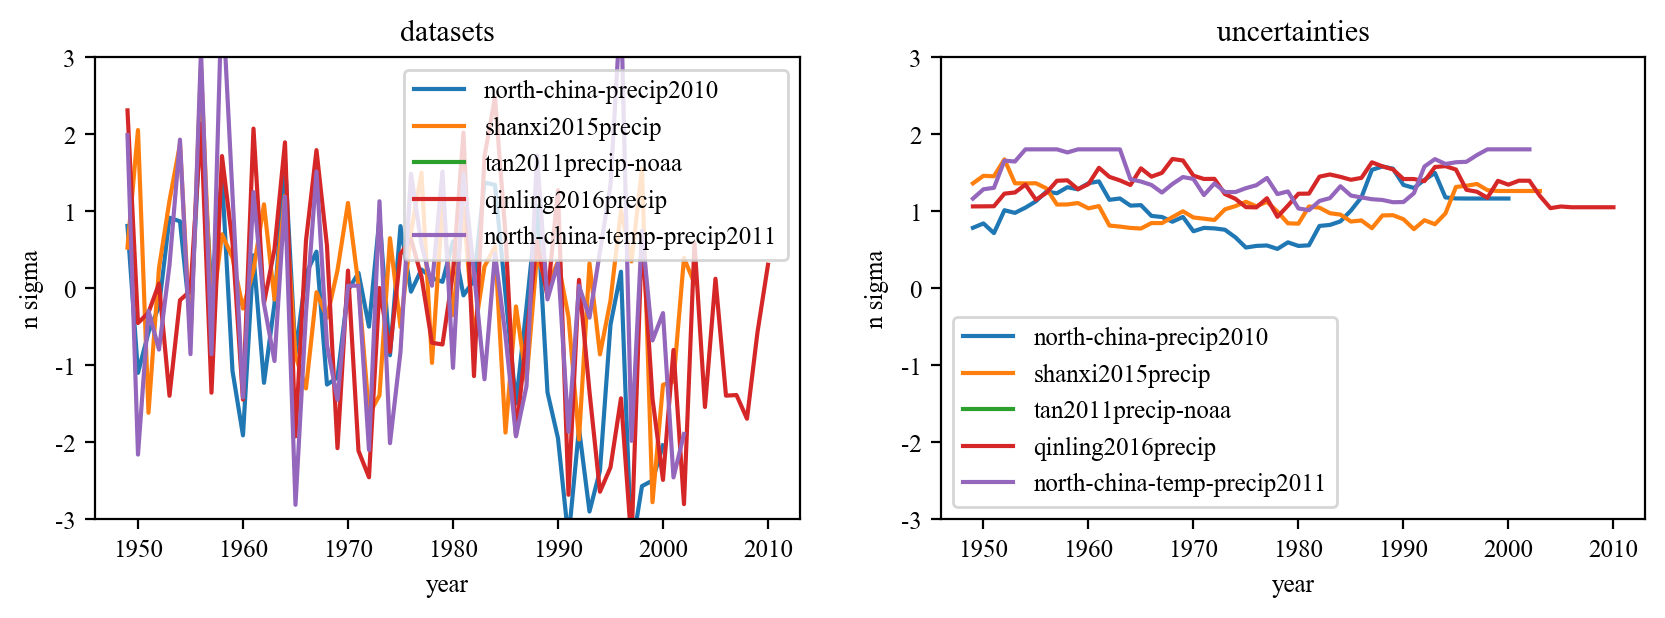

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
datasets.loc[1949:].plot(ax=ax[0])
uncertainties.loc[1949:].plot(ax=ax[1])
ax[0].set_title("datasets")
ax[1].set_title("uncertainties")
for a in ax:
    a.set_ylabel("n sigma")
    a.set_ylim(-3, 3)
plt.show();

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'true_drought'}>,
        <Axes: title={'center': 'true_drought'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>]],
      dtype=object)

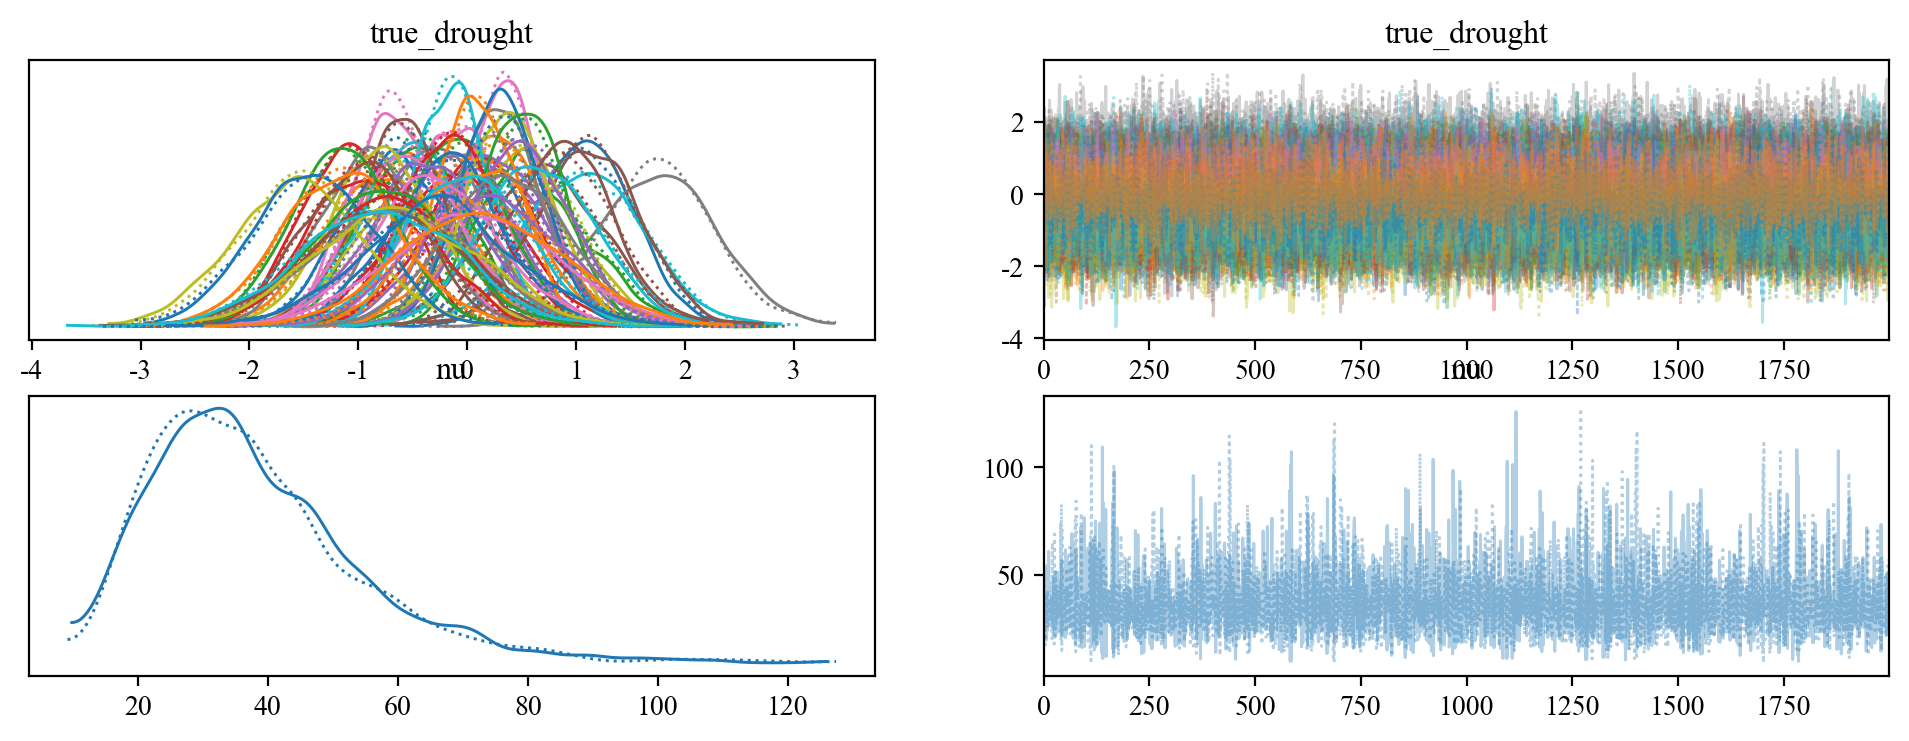

In [5]:
from past1000.api.mc import combine_reconstructions
import arviz as az

combined, trace = combine_reconstructions(
    datasets.loc[1949:],
    uncertainties.loc[1949:],
    standardize=False,
)

az.plot_trace(trace, var_names=["true_drought", "nu"])

把历史数据中的各个站点进行聚合的方法我尝试了：

1. 众数
2. 平均数+取整

效果目前看起来都差不多

1960年，Cohen 等人提出使用Kappa 值！作力判断评价一致性程度指标，目前在医疗等行业得到广泛的
应用，已经成为判断一致性？和信用度评价的一种常用统计学重要指标。Kappa 值的可能取值范围是从-1到
1,Kappa 值小于0.7时表示测量系统不合格，在0.7~0.9 时表示测量系统可接受，大于等于0.9时表示测量系统良好（[参考知乎](https://www.zhihu.com/question/28884747?sort=created)）。

$$ k=\frac{P_{\mathrm{o}}-p_{\mathrm{e}}}{1-p_{\mathrm{e}}} $$

其中Po为编码一致的样本比例，Pe为编码不一致样本计算出的偶然预期一致性比例。其中Pe的计算为：

$$ p_{\mathrm{e}}=\frac{1}{n^2} \sum_{m=1}^4 f_{i m} \cdot f_{j m} $$

> [!info]
> 关于linear还是quadratic weighted kappa的选择，取决于你的数据集中不同class之间差异的意义。比如对于眼底图像识别的数据，class=0为健康，class=4为疾病晚期非常严重，所以对于把class=0预测成4的行为所造成的惩罚应该远远大于把class=0预测成class=1的行为，使用quadratic的话0->4所造成的惩罚就等于16倍的0->1的惩罚。

具体实现上，可以使用 [sklearn 的 `cohen_kappa_score` 函数](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html)，其中 weights 参数可以设置为 'linear' 或 'quadratic'。

<Axes: title={'center': "Kappa: 0.61, Kendall's Tau: 0.58**"}, xlabel='Predicted label', ylabel='True label'>

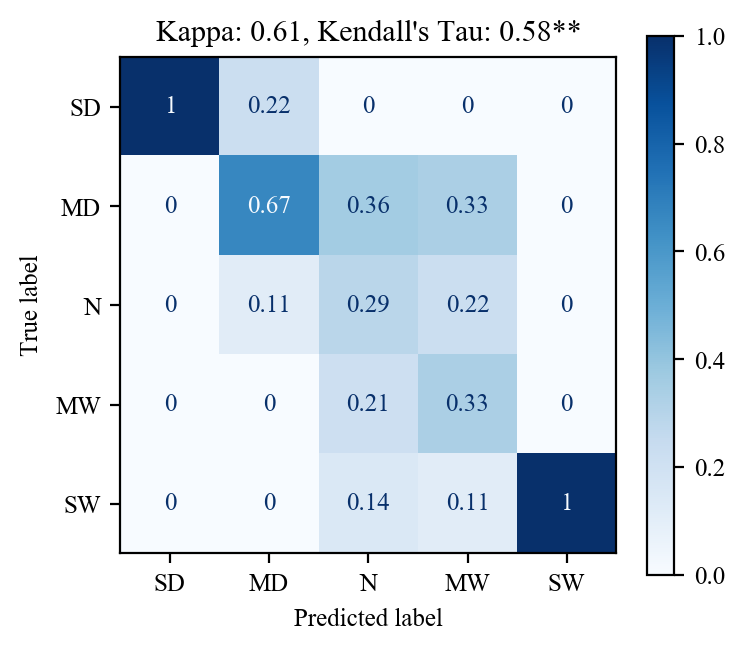

In [6]:
from past1000.viz.plot import plot_confusion_matrix
from past1000.api.series import HistoricalRecords
from past1000.filters import classify

# 历史记录
stage4 = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
).stage4
y_true = stage4.mode(axis=1)[0]

# 对比历史记录和分类结果
classification = classify(combined["mean"]).loc[1949:2010]
y_pred = classification.loc[1949:2010]

plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    dropna=True,
)

(1) Cohen's Kappa (κ) = 0.60

Landis & Koch (1977) 标准：

1. 0.61–0.80：显著一致性（Substantial Agreement）
2. 0.60 处于"中等"（Moderate）和"显著"（Substantial）的边界，但更接近"显著"。

实际意义：模型预测与真实标签的一致性较好，已超过随机猜测较多，适用于多数应用场景。

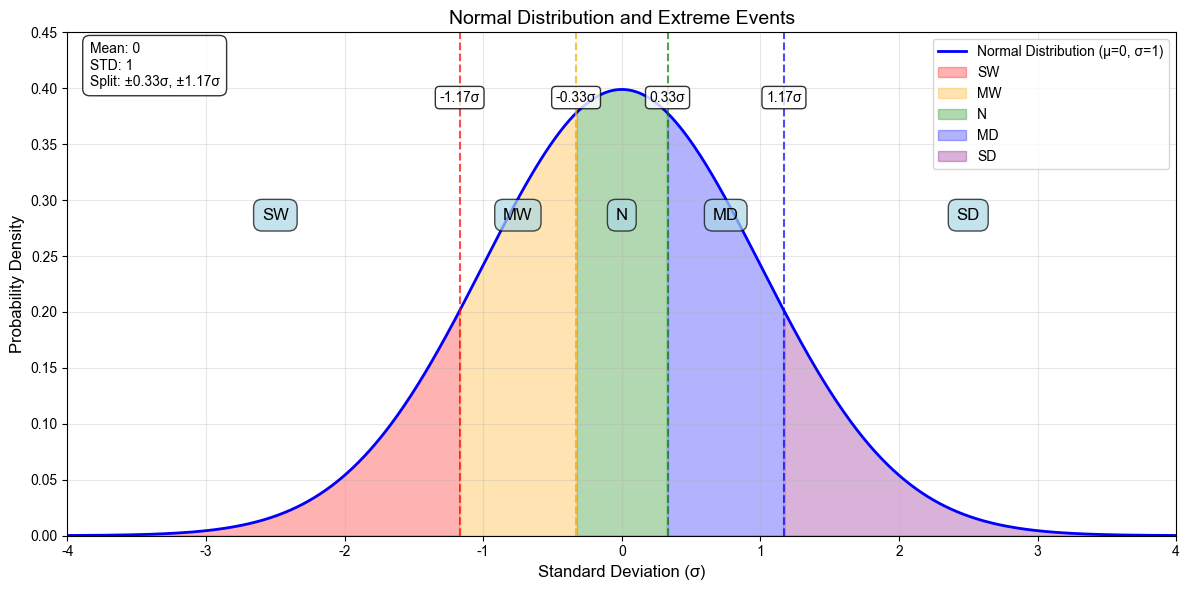

In [5]:
# 正态分布示意图

# ... existing code ...

# 正态分布示意图
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# 创建图形
fig, ax = plt.subplots(figsize=(12, 6))

# 生成正态分布数据
x = np.linspace(-4, 4, 1000)
y = norm.pdf(x, 0, 1)  # 均值0，标准差1

# 绘制正态分布曲线
ax.plot(x, y, "b-", linewidth=2, label="Normal Distribution (μ=0, σ=1)")

# 定义分割点
split_points = [-1.17, -0.33, 0.33, 1.17]
labels = ["SW", "MW", "N", "MD", "SD"]

# 绘制垂直线并添加标签
colors = ["red", "orange", "green", "blue"]
for i, (point, color) in enumerate(zip(split_points, colors)):
    ax.axvline(x=point, color=color, linestyle="--", alpha=0.7, linewidth=1.5)
    ax.text(
        point,
        ax.get_ylim()[1] * 0.95,
        f"{point:.2f}σ",
        ha="center",
        va="top",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
    )

# 添加区域标签
x_regions = [-2.5, -0.75, 0, 0.75, 2.5]  # 每个区域的中心位置
for i, (x_pos, label) in enumerate(zip(x_regions, labels)):
    ax.text(
        x_pos,
        ax.get_ylim()[1] * 0.7,
        label,
        ha="center",
        va="top",
        fontsize=12,
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7),
    )

# 填充区域颜色
ax.fill_between(x, y, where=(x <= -1.17), alpha=0.3, color="red", label="SW")
ax.fill_between(
    x, y, where=((x > -1.17) & (x <= -0.33)), alpha=0.3, color="orange", label="MW"
)
ax.fill_between(
    x, y, where=((x > -0.33) & (x <= 0.33)), alpha=0.3, color="green", label="N"
)
ax.fill_between(
    x, y, where=((x > 0.33) & (x <= 1.17)), alpha=0.3, color="blue", label="MD"
)
ax.fill_between(x, y, where=(x > 1.17), alpha=0.3, color="purple", label="SD")

# 设置图形属性
ax.set_xlabel("Standard Deviation (σ)", fontsize=12)
ax.set_ylabel("Probability Density", fontsize=12)
ax.set_title("Normal Distribution and Extreme Events", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.set_xlim(-4, 4)
ax.set_ylim(0, 0.45)

# 添加图例
ax.legend(loc="upper right", fontsize=10)

# 添加统计信息
stats_text = f"Mean: 0\nSTD: 1\nSplit: ±0.33σ, ±1.17σ"
ax.text(
    0.02,
    0.98,
    stats_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()